In [8]:
import requests
import pandas as pd

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

params = {
    "format": "geojson",
    "starttime": "2013-01-01",
    "endtime": "2024-10-28",
    "minmagnitude": 4,
    "maxmagnitude": 10,
    "minlatitude": 24.0,
    "maxlatitude": 45.5,
    "minlongitude": 122.0,
    "maxlongitude": 153.0
}


response = requests.get(url, params=params)

if response.status_code == 200:

    data = response.json()

    earthquake = pd.json_normalize(data['features'])


    earthquake = earthquake[['properties.time', 'properties.place', 'properties.mag', 'geometry.coordinates']]
    earthquake['properties.time'] = pd.to_datetime(earthquake['properties.time'], unit='ms')


    # earthquake.to_csv("earthquake.csv", index=False)

else:
    print("요청 실패, 상태 코드:", response.status_code)
    print("오류 메시지:", response.text)


In [33]:
earthquake_data = earthquake.copy()

In [34]:
len(earthquake_data)

13600

In [69]:
earthquake_data.tail()

,location,magnitude,coordinates,magnitude_MA
2024-10-25,"103 km ESE of Tomioka, Japan",4.7,"[142.113, 37.0211, 35]",4.605000
2024-10-25,"59 km S of Shikotan, Russia",4.9,"[146.6395, 43.2631, 82.22]",4.615000
2024-10-25,"Izu Islands, Japan region",4.6,"[141.7206, 31.9498, 10]",4.635000
2024-10-26,"Bonin Islands, Japan region",4.0,"[139.5873, 27.7938, 491.885]",4.611667
2024-10-27,"10 km NW of Hitachi, Japan",4.4,"[140.5574, 36.6581, 62.493]",4.595000


In [36]:
earthquake_data.columns = ['date', 'location', 'magnitude', 'coordinates']


In [37]:
earthquake_data['date'] = earthquake_data['date'].astype(str)
earthquake_data['date'] = earthquake_data['date'].apply(lambda x: x[:11])
earthquake_data['date'] = pd.to_datetime(earthquake_data['date'])
earthquake_data = earthquake_data.set_index('date')

<Axes: >

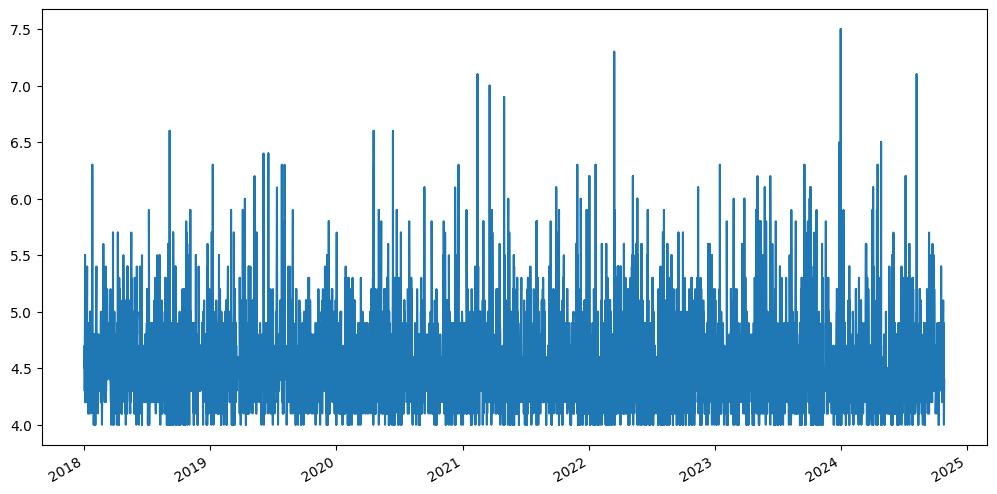

In [70]:

full_range = pd.date_range(start=earthquake_data.index.min(),
                           end=earthquake_data.index.max(), freq='D')

full_data = pd.DataFrame(index=full_range)

earthquake_data = full_data.join(earthquake_data)

earthquake_data['magnitude'] = earthquake_data['magnitude'].interpolate(method='linear')

condition = earthquake_data.index > '2018-01-01'
filtered = earthquake_data.loc[condition, 'magnitude']

filtered.plot(figsize=(12.2, 6.4))

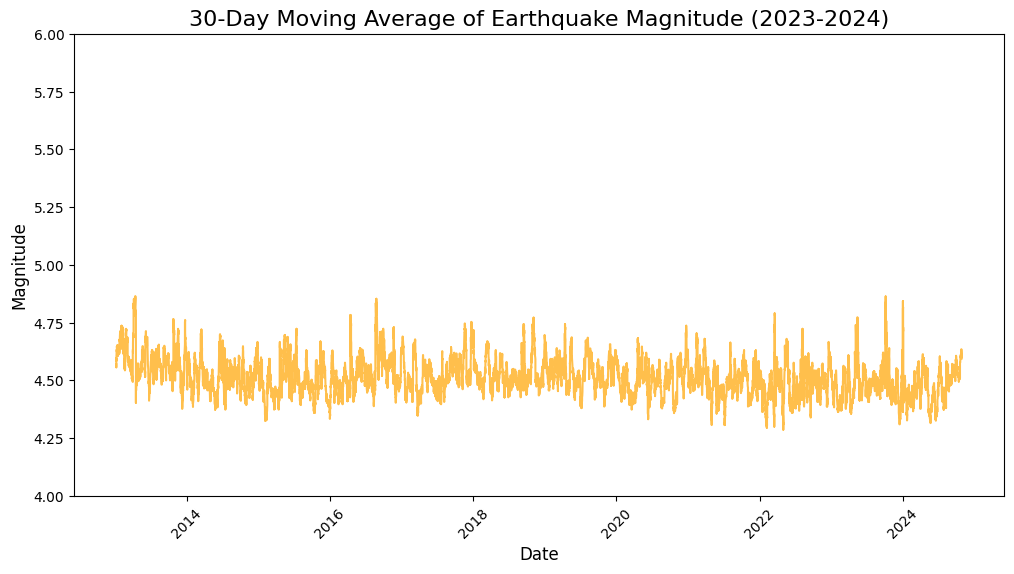

In [43]:
import matplotlib.pyplot as plt

earthquake_data['magnitude_MA'] = earthquake_data['magnitude'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(earthquake_data.index, earthquake_data['magnitude_MA'], color='orange', alpha=0.7)
plt.title("30-Day Moving Average of Earthquake Magnitude (2023-2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Magnitude", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(4, 6)
plt.show()


In [44]:
from statsmodels.tsa.stattools import adfuller

print('ADF test with earthquake time-series')
ADF_result = adfuller(earthquake_data['magnitude'])
#ADF 통계량
print('ADF Stats: %f' % ADF_result[0])
#p-값
print('p-value: %f' % ADF_result[1])
#임계값
print('Critical values:' )
for key, value in ADF_result[4].items():
    print('\t%s: %.4f' % (key, value))

ADF test with earthquake time-series
ADF Stats: -21.742667
p-value: 0.000000
Critical values:
	1%: -3.4308
	5%: -2.8617
	10%: -2.5669


In [45]:
import sklearn.preprocessing

scaler = sklearn.preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(earthquake_data['magnitude'].values.reshape(-1,1))


In [48]:
def load_data(data, seq_len):
    X = []
    y = []

    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i, 0])
        y.append(data[i, 0])
    return X, y

In [49]:
seq_len = 30
X, y = load_data(scaled_data, seq_len)

In [50]:
num = int(len(earthquake_data['magnitude']) * 0.8)
num

11136

In [51]:
X_train = X[:num]
y_train = y[:num]
X_test = X[num:]
y_test = y[num:]

In [52]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [53]:
X_train = np.reshape(X_train, (len(X_train), seq_len, 1))
X_test = np.reshape(X_test, (len(X_test), seq_len, 1))

In [54]:
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (11136, 30, 1)
y_train.shape =  (11136,)
x_test.shape =  (2755, 30, 1)
y_test.shape =  (2755,)


In [55]:
import tensorflow as tf
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, Bidirectional
from keras.models import Sequential

In [57]:
model_lstm = Sequential()

model_lstm.add((LSTM(64, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=True)))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(44, activation='tanh', return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(24, activation='tanh'))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(1))

model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 44)              │          19,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 24)                  │           6,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,965 (167.83 KB)

 Trainable params: 42,965 (167.83 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 모델 컴파일
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 모델 훈련
history = model_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0092 - mean_absolute_error: 0.0693
Epoch 2/10
  5/348 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0049 - mean_absolute_error: 0.0551

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error
  current = self.get_monitor_value(logs)


348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 0.0092 - mean_absolute_error: 0.0683
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 0.0094 - mean_absolute_error: 0.0686
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.0092 - mean_absolute_error: 0.0686
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.0090 - mean_absolute_error: 0.0684
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0089 - mean_absolute_error: 0.0676
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0094 - mean_absolute_error: 0.0686
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0091 - mean_absolute_error: 0.0677
Epoch 9/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0089 - mean_absolute_error: 0.0680
Epoch 10/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0091 - mean_absolute_error: 0.0686


In [61]:
from sklearn.metrics import r2_score

lstmPredict = model_lstm.predict(X_test)
lstmScore = r2_score(y_test, lstmPredict)
print("R2 Score : ", lstmScore)
lstmPredict.shape

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
R2 Score :  0.0032530464329045827


(2755, 1)

In [62]:
rnnModel = Sequential()
rnnModel.add(SimpleRNN(40, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1],1)))
rnnModel.add(Dropout(0.15))
rnnModel.add(SimpleRNN(50, return_sequences=True, activation="tanh"))
rnnModel.add(Dropout(0.1))
rnnModel.add(SimpleRNN(10, activation="tanh"))
rnnModel.add(Dropout(0.2))
rnnModel.add(Dense(1))
rnnModel.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 30, 40)              │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 30, 50)              │           4,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 10)                  │             610 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,851 (26.76 KB)

 Trainable params: 6,851 (26.76 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
rnnModel.compile(optimizer="adam", loss="MSE")
rnnModel.fit(X_train, y_train, epochs=20, batch_size=50)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.1660
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0200
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0134
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0116
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0108
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0101
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.0098
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0100
Epoch 9/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0093
Epoch 10/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0094
Epoch 11/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0089
Epoch 12/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0093
Epoch 13/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0093
Epoch 14/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0090
Epoch 15/20
223/223 ━━━━━━━━━━━━━━━━

In [66]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lstmPredict = model_lstm.predict(X_test)
lstmScore = r2_score(y_test, lstmPredict)
print("R2 Score : ", lstmScore)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, lstmPredict)
print("MAE: ", mae)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, lstmPredict)
print("MSE: ", mse)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
R2 Score :  0.0032530464329045827
MAE:  0.06799642804649612
MSE:  0.00919536535955403
